In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence, pack_sequence, pad_packed_sequence
from tqdm.auto import tqdm
from utils import find_file_by_stem

torch.set_printoptions(sci_mode=False)
RANDOM_SEED = 1
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Colab: download dataset
!gdown https://drive.google.com/uc?id=1xmDzRIv-RuPeqLDGY2zfOiiNAbyZp6jo
!unzip -qq osu_dataset-06-16.zip

Downloading...
From: https://drive.google.com/uc?id=1xmDzRIv-RuPeqLDGY2zfOiiNAbyZp6jo
To: /content/osu_dataset-06-16.zip
100% 4.96G/4.96G [01:00<00:00, 82.3MB/s]


In [ ]:
class OsuDataset:
    """
    Beatmap + audio dataset.
    GETITEM: specs, beat_phase, beat_num, difficulty, onsets, actions
    """

    def __init__(self, beatmap_path, audio_path):
        self.beatmap_fns = sorted(list(beatmap_path.glob('*.pt')))
        self.audio_fns = list(audio_path.glob('*.pt'))

    def __len__(self):
        return len(self.beatmap_fns)

    def __getitem__(self, idx):
        beatmap_fn = self.beatmap_fns[idx]
        audio_fn = find_file_by_stem(self.audio_fns, beatmap_fn.stem.split('-')[0])
        if audio_fn == -1:
            raise FileNotFoundError
        actions, onsets, _, difficulty = torch.load(beatmap_fn).values()
        specs, beat_phase, beat_num = torch.load(audio_fn).values()
        return specs, beat_phase, beat_num, difficulty, onsets, actions

In [ ]:
class PadCollater:
    def __init__(self, device):
        self.device = device

    def __call__(self, batch):
        specs = []
        beat_phases = []
        beat_nums = []
        difficulties = []
        onsets = []
        actions = []
        lengths = []

        for x in batch:
            specs.append(x[0].to(self.device))
            lengths.append(x[0].shape[1])
            beat_phases.append(x[1].to(self.device))
            beat_nums.append(x[2].to(self.device))
            difficulties.append(x[3])
            onsets.append(x[4].to(self.device))
            actions.append(x[5].to(self.device))

        beat_phases = pad_sequence(beat_phases, batch_first=True)
        beat_nums = pad_sequence(beat_nums, batch_first=True)
        difficulties = torch.tensor(difficulties, device=self.device)
        actions = pad_sequence(actions, batch_first=True)
        lengths = torch.tensor(lengths, device=self.device)

        return specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths

In [ ]:
class OsuModel(nn.Module):
    def __init__(self, device, bp_emb_dim=16, bn_emb_dim=8, diff_emb_dim=8,
                 np_hidden_size=256, np_num_layers=2, ns_pre_proj_size=32,
                 ns_hidden_size=256, ns_num_layers=2, num_tokens=256):
        super().__init__()
        self.device = device
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.conv = nn.Conv2d(in_channels=3,
                              out_channels=1,
                              kernel_size=(15, 5),
                              padding='same')
        self.beat_phase_emb = nn.Embedding(49, bp_emb_dim)
        self.beat_num_emb = nn.Embedding(4, bn_emb_dim)
        self.difficulty_emb = nn.Embedding(20, diff_emb_dim)

        self.np_gru = nn.GRU(input_size=80 + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=np_hidden_size,
                             num_layers=np_num_layers,
                             batch_first=True,
                             bidirectional=True)
        self.np_proj_1 = nn.Linear(np_hidden_size*2, 128)
        self.np_proj_2 = nn.Linear(128, 1)

        self.ns_pre_proj = nn.Linear(128, ns_pre_proj_size)
        self.ns_gru = nn.GRU(input_size=80 + ns_pre_proj_size + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=ns_hidden_size,
                             num_layers=ns_num_layers,
                             batch_first=True,
                             bidirectional=False)
        self.ns_proj_1 = nn.Linear(ns_hidden_size, ns_hidden_size)
        self.ns_proj_2 = nn.Linear(ns_hidden_size, num_tokens)

    def forward(self, specs, beat_phases, beat_nums, difficulties, lengths):
        conv_outs = [self.gelu(self.conv(spec)).squeeze() for spec in specs]
        bp_emb = unpad_sequence(self.beat_phase_emb(beat_phases).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        bn_emb = unpad_sequence(self.beat_num_emb(beat_nums).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        diff_emb = self.difficulty_emb(difficulties)

        # ========== Note Placement ========== #

        np_in = []
        for i in range(len(lengths)):
            np_in.append(torch.cat([conv_outs[i],
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].expand(lengths[i], diff_emb[i].shape[-1])],
                                   dim=-1))
        np_in_packed = pack_sequence(np_in, enforce_sorted=False)
        np_out, last_hidden = self.np_gru(np_in_packed)
        np_out_padded, lengths = pad_packed_sequence(np_out, batch_first=True)

        np_proj_1_out = self.gelu(self.np_proj_1(np_out_padded))
        np_pred = self.sigmoid(self.np_proj_2(np_proj_1_out)).squeeze()

        # ========== Note Selection ========== #

        ns_pre_proj_padded = self.ns_pre_proj(np_proj_1_out)
        ns_pre_proj = unpad_sequence(ns_pre_proj_padded, lengths, batch_first=True)
        ns_in = []
        for i in range(len(lengths)):
            ns_in.append(torch.cat([conv_outs[i],
                                    ns_pre_proj[i].to(self.device),
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].expand(lengths[i], diff_emb[i].shape[-1])],
                                   dim=-1))
        ns_in_packed = pack_sequence(ns_in, enforce_sorted=False)
        ns_out, last_hidden = self.ns_gru(ns_in_packed)
        ns_out_padded, lengths = pad_packed_sequence(ns_out, batch_first=True)

        ns_proj_1_out = self.gelu(self.ns_proj_1(ns_out_padded))
        ns_logit = self.ns_proj_2(ns_proj_1_out)

        return np_pred, ns_logit

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, valid_loader, device,
                 np_fl_gamma=2, np_fl_weight=0.8,
                 ns_fl_gamma=2, ns_fl_weight=0.8):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.np_fl_gamma=np_fl_gamma
        self.np_fl_weight=np_fl_weight
        self.ns_fl_gamma=ns_fl_gamma
        self.ns_fl_weight=ns_fl_weight

        self.train_np_loss_record = []
        self.train_ns_loss_record = []
        self.train_loss_record = []
        self.valid_np_loss_record = []
        self.valid_ns_loss_record = []
        self.valid_loss_record = []

        # TODO: metrics (Perplexity, F-score, AUC...)

    def binary_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Biary focal loss for when y=1 is the minority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        return -(y * (1-pred).pow(gamma) * pred.log() +
                 pos_weight * (1-y) * pred.pow(gamma) * (1-pred).log()).mean()

    def multi_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Multi-class focal loss for when y=0 is the majority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        p_y = pred[torch.arange(len(pred)), y]
        weight_mask = torch.where(y == 0, pos_weight, 1)
        return -(weight_mask * (1 - p_y).pow(gamma) * p_y.log()).mean()

    def train(self, num_epochs, reset_loss_record=False):
        self.model.to(self.device)
        if reset_loss_record:
            self.train_loss_record = []
            self.valid_loss_record = []

        for epoch in tqdm(range(num_epochs)):
            self.model.train()
            for batch in tqdm(self.train_loader, leave=False):
                specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths = batch

                np_pred_padded, ns_logit = self.model(
                    specs, beat_phases, beat_nums, difficulties, lengths)

                np_pred = torch.cat(unpad_sequence(
                    np_pred_padded.to('cpu'), lengths.to('cpu'), batch_first=True), dim=-1)
                np_label = torch.cat(onsets, dim=-1).to('cpu')

                ns_pred = torch.cat(unpad_sequence(
                    ns_logit.to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=0).softmax(dim=-1)
                ns_label = torch.cat(unpad_sequence(
                    actions[:, 1:].to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=-1)

                np_loss = self.binary_focal_loss(
                    np_label, np_pred, self.np_fl_gamma, self.np_fl_weight)
                ns_loss = self.multi_focal_loss(
                    ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                batch_loss = np_loss + ns_loss
                self.train_np_loss_record.append(np_loss.item())
                self.train_ns_loss_record.append(ns_loss.item())
                self.train_loss_record.append(batch_loss.item())

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

            self.model.eval()
            with torch.inference_mode():
                for batch in tqdm(self.valid_loader, leave=False):
                    specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths = batch

                    np_pred_padded, ns_logit = self.model(
                        specs, beat_phases, beat_nums, difficulties, lengths)

                    np_pred = torch.cat(unpad_sequence(
                        np_pred_padded.to('cpu'), lengths.to('cpu'), batch_first=True), dim=-1)
                    np_label = torch.cat(onsets, dim=-1).to('cpu')

                    ns_pred = torch.cat(unpad_sequence(
                        ns_logit.to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=0).softmax(dim=-1)
                    ns_label = torch.cat(unpad_sequence(
                        actions[:, 1:].to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=-1)

                    np_loss = self.binary_focal_loss(
                        np_label, np_pred, self.np_fl_gamma, self.np_fl_weight)
                    ns_loss = self.multi_focal_loss(
                        ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                    batch_loss = np_loss + ns_loss
                    self.valid_np_loss_record.append(np_loss.item())
                    self.valid_ns_loss_record.append(ns_loss.item())
                    self.valid_loss_record.append(batch_loss.item())

In [ ]:
beatmap_path = Path('osu_dataset/test/4keys/')
audio_path = Path('osu_dataset/test/')

base_set = OsuDataset(beatmap_path, audio_path)
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, valid_set = torch.utils.data.random_split(
    base_set, [0.8, 0.2], generator)

collater = PadCollater(device=DEV)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, generator=generator, collate_fn=collater, drop_last=True)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=4, shuffle=False, collate_fn=collater, drop_last=True)

model = OsuModel(device=DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, train_loader, valid_loader,
                  device=DEV, ns_fl_gamma=2, ns_fl_weight=0.8,
                  np_fl_gamma=2, np_fl_weight=0.5)

### Training Test

In [ ]:
trainer.train(2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

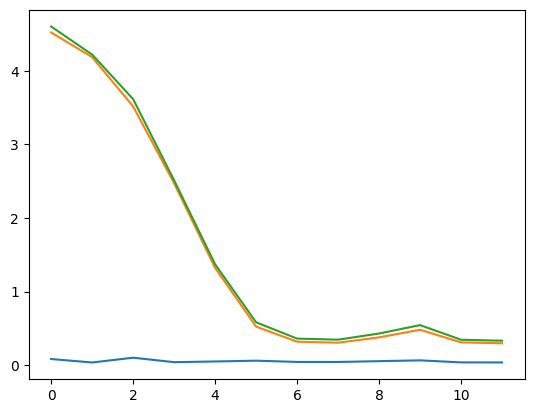

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainer.train_np_loss_record)
plt.plot(trainer.train_ns_loss_record)
plt.plot(trainer.train_loss_record)